### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Creating DFs

In [5]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')

In [7]:
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==1)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)

In [22]:
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df

#.sort_values(by='Count')

## Baseline Model (No Data Cleaning)

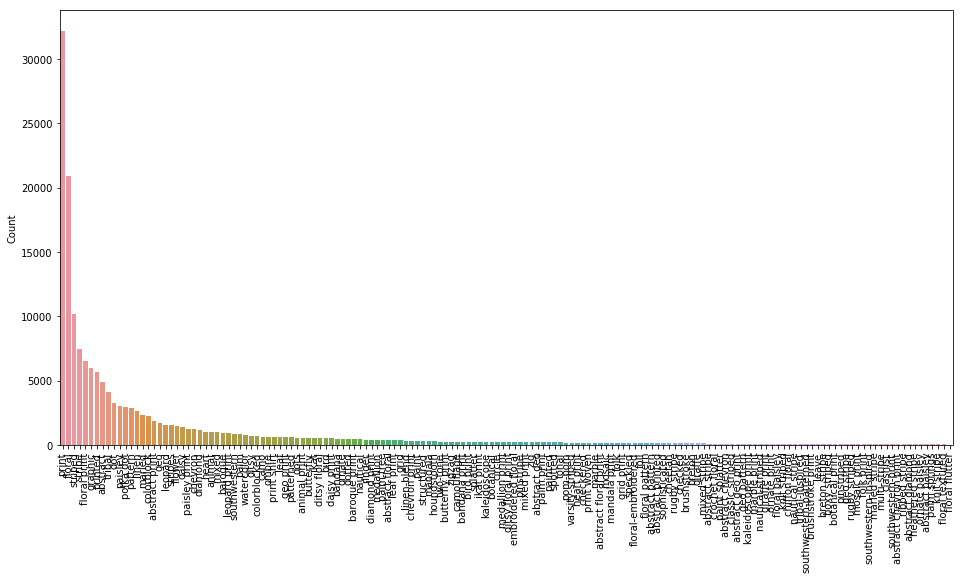

In [15]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

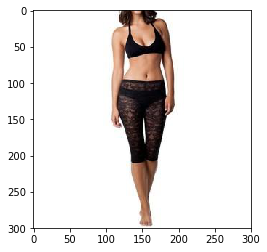

In [565]:
from matplotlib import image

# load the image
data = image.imread('./Img/img/Side-Cutout_Capri_Leggings/img_00000028.jpg')

plt.imshow(data)
plt.show()

In [16]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [23]:
# take all the columns after the first "image_name" col
label_column_names = training_df.columns.tolist()[1:]

img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=150, label_col=label_column_names)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (76848 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
sophisticated,print,camo,printed,paisley
Path: Img;

Valid: LabelList (19212 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
striped,tribal-inspired,graphic,daisy;dot;polka dot,clashist
Path: Img;

Test: None

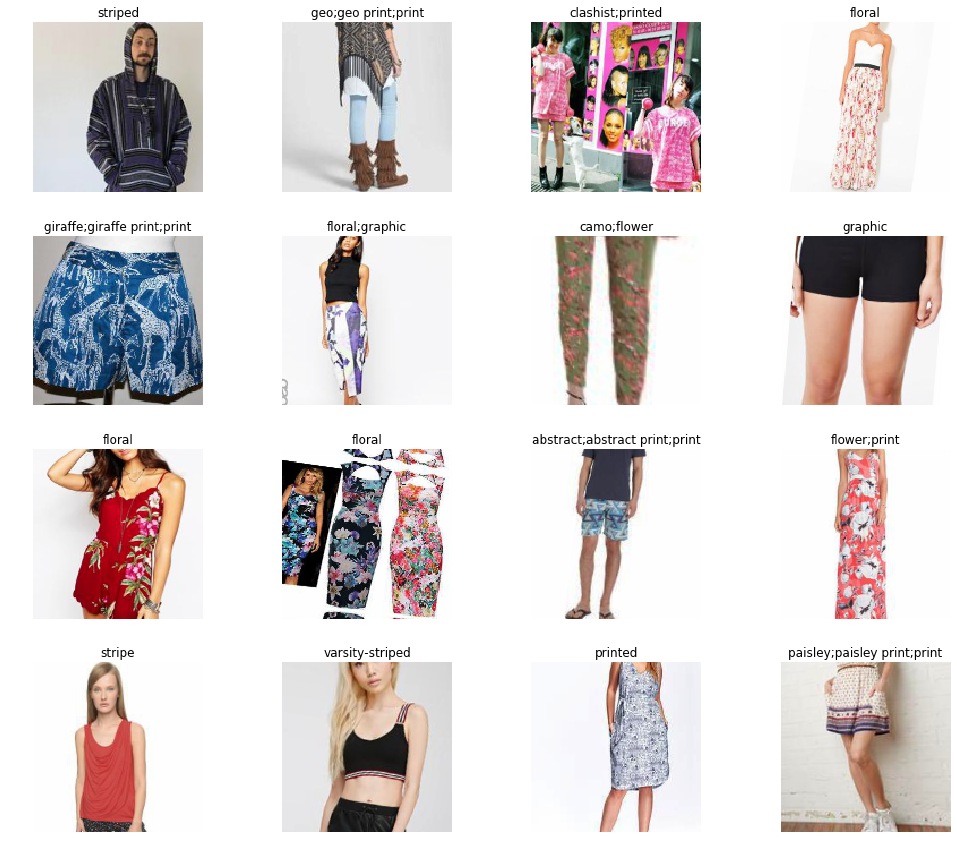

In [24]:
data.show_batch(rows=4, figsize=(14,12))

In [25]:
print(data.classes)
len(data.classes),data.c


['abstract', 'abstract chevron', 'abstract chevron print', 'abstract diamond', 'abstract floral', 'abstract floral print', 'abstract geo', 'abstract geo print', 'abstract paisley', 'abstract pattern', 'abstract print', 'abstract printed', 'abstract stripe', 'animal', 'animal print', 'bandana', 'bandana print', 'baroque', 'baroque print', 'bird', 'bird print', 'botanical', 'botanical print', 'boxy striped', 'breton', 'breton stripe', 'brushstroke', 'brushstroke print', 'butterfly', 'butterfly print', 'camo', 'camouflage', 'checked', 'checkered', 'cheetah', 'chevron', 'chevron print', 'chiffon floral', 'circle', 'clashist', 'classic striped', 'colorblock', 'colorblocked', 'crochet floral', 'daisy', 'daisy print', 'diamond', 'diamond print', 'ditsy', 'ditsy floral', 'ditsy floral print', 'dot', 'dots', 'dotted', 'embroidered floral', 'floral', 'floral flutter', 'floral paisley', 'floral pattern', 'floral print', 'floral textured', 'floral-embroidered', 'flower', 'foil', 'folk', 'folk prin

(156, 156)

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=fbeta, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,fbeta,time
0,0.039514,0.037898,0.374826,03:11
1,0.036400,0.035633,0.425106,03:09
2,0.035768,0.034745,0.441560,03:09
3,0.035402,0.034051,0.449432,03:09
4,0.034911,0.033704,0.458361,03:09
5,0.033871,0.033466,0.465828,03:08
6,0.033644,0.033369,0.463146,03:08
7,0.033842,0.033338,0.464456,03:09


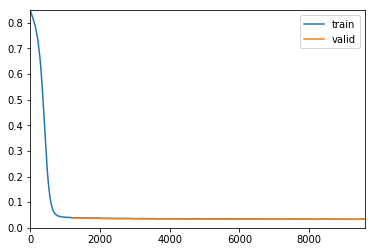

In [28]:
learn.fit_one_cycle(8)

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


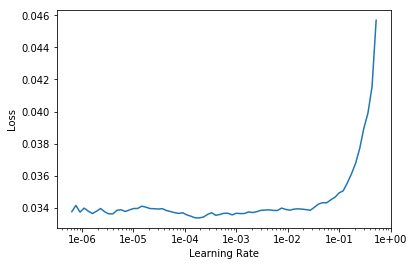

In [30]:
learn.recorder.plot()

epoch,train_loss,valid_loss,fbeta,time
0,0.033219,0.033318,0.464673,03:09
1,0.033497,0.033316,0.464446,03:09
2,0.033749,0.033286,0.466076,03:09
3,0.033457,0.033304,0.463782,03:09


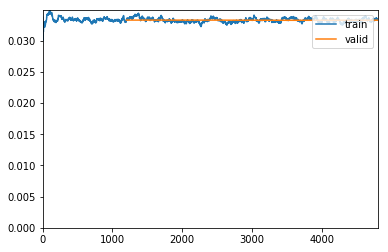

In [31]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,fbeta,time
0,0.033652,0.033181,0.467983,04:11
1,0.033210,0.032941,0.473592,04:11
2,0.032381,0.032772,0.477756,04:10
3,0.032592,0.032746,0.478222,04:11


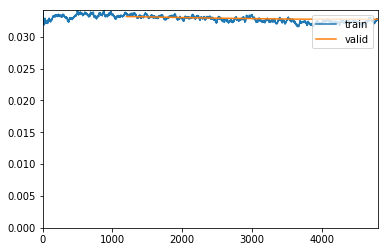

In [32]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

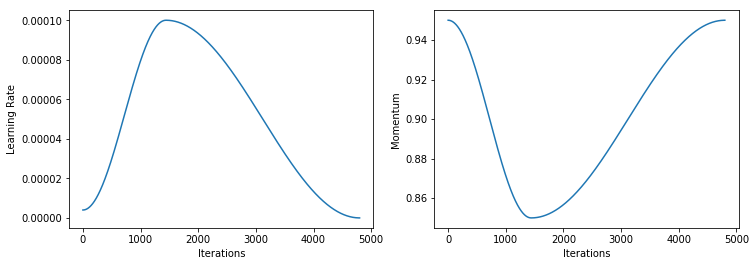

In [33]:
learn.recorder.plot_lr(show_moms=True)

In [34]:
learn.save('texture-resnet50-size150-fr12-unfr4', return_path=True)

PosixPath('Img/models/texture-resnet50-size150-fr12-unfr4.pth')

In [35]:
learn.export('texture-resnet50-size150-fr12-unfr4.pkl')

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

8885 misclassified samples over 19212 samples in the validation set.


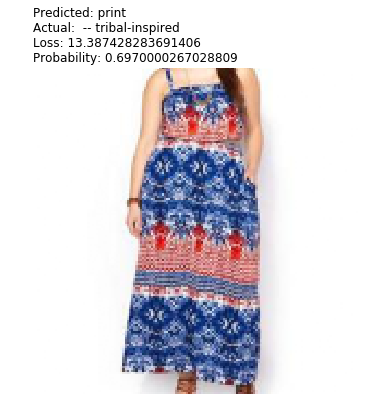

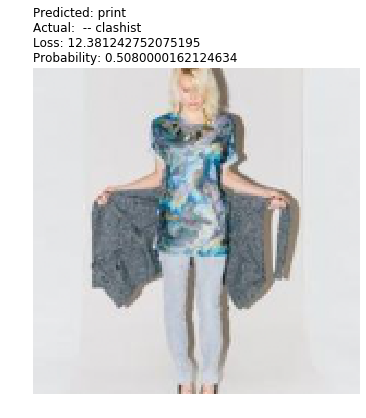

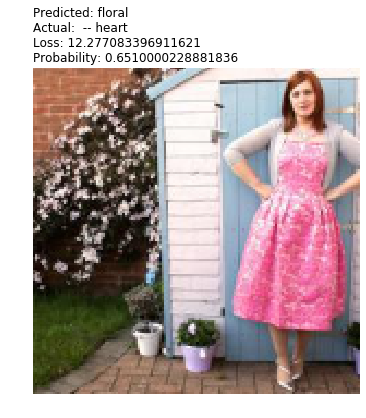

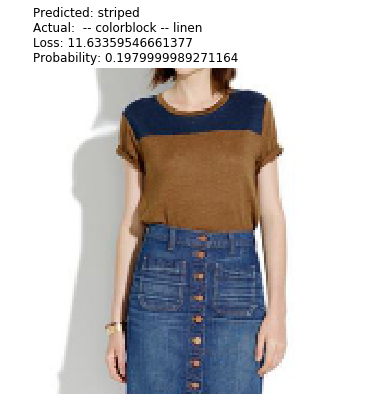

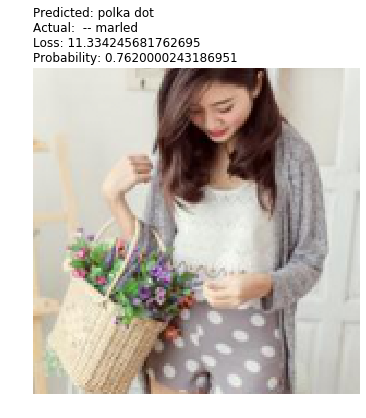

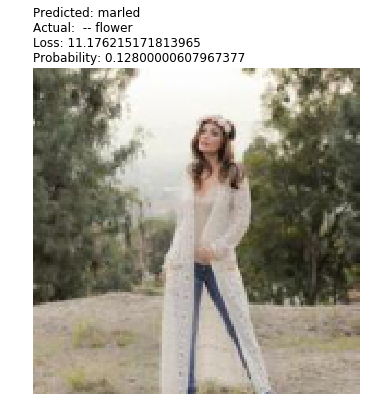

In [37]:
interp.plot_multi_top_losses(6, figsize=(8,6))

[('striped', 0.2525131106376648), ('floral', 0.21563443541526794), ('print', 0.1451069563627243), ('stripe', 0.11117126047611237), ('stripes', 0.05838625133037567)]


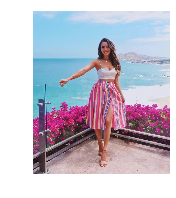

In [38]:
predict_img_path = "pink.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))

# "/data/Michael/data/predict/2.png"

## Cleaning Data to Reduce Class Imbalance

In [39]:
col_df = count_attr_imgs(training_df).sort_values(by='Count')
col_df

,Count
floral flutter,40
floral textured,45
knit stripe,46
palm springs,46
abstract paisley,47
ornate paisley,48
heathered stripe,48
abstract diamond,48
ribbed stripe,49
abstract chevron print,50


In [45]:
def drop_list(category, drop_num, df):
    cat_index = df[(df[category]== True)].index.tolist()
    drop_cat = np.random.choice(cat_index, drop_num, replace=False)
    return drop_cat.tolist()

def drop_images_from_list(df, indices_to_drop):
    return df.drop(indices_to_drop).copy()

In [49]:
drop_print = drop_list('print', 25000, training_df)
cleaned_df = drop_images_from_list(training_df, drop_print)
count_attr_imgs(cleaned_df).sort_values(by='Count')

,Count
folk print,13
abstract chevron print,14
ornate print,15
botanical print,16
mosaic print,18
brushstroke print,19
giraffe print,21
abstract diamond,23
kaleidoscope print,25
marble print,26


In [50]:
drop_floral = drop_list('floral', 9000, cleaned_df)
cleaned_df = drop_images_from_list(cleaned_df, drop_floral)
count_attr_imgs(cleaned_df).sort_values(by='Count')

,Count
folk print,11
abstract floral print,13
ornate print,14
botanical print,14
abstract chevron print,14
mosaic print,16
floral flutter,16
brushstroke print,18
floral textured,20
giraffe print,21


In [51]:
drop_striped = drop_list('striped', 4000, cleaned_df)
cleaned_df = drop_images_from_list(cleaned_df, drop_striped)
count_attr_imgs(cleaned_df).sort_values(by='Count')

,Count
folk print,11
abstract floral print,13
ornate print,14
abstract chevron print,14
botanical print,14
floral flutter,16
mosaic print,16
brushstroke print,18
floral textured,20
giraffe print,21


In [52]:
cleaned_col_df = count_attr_imgs(cleaned_df).sort_values(by='Count')
attr_to_remove = cleaned_col_df[cleaned_col_df['Count']<500].index.tolist()

In [54]:
cleaned_df.drop(attr_to_remove, axis=1, inplace=True)

In [55]:
cleaned_df.reset_index(drop=True, inplace=True)

In [56]:
cleaned_df['max'] = [cleaned_df.iloc[x][1:].max() for x in cleaned_df.index.tolist()]
cleaned_df = cleaned_df[cleaned_df['max'].isin([True])].copy()
cleaned_df.drop('max', axis=1, inplace=True)

In [57]:
count_attr_imgs(cleaned_df).sort_values(by='Count')

,Count
dots,514
camo,535
patterned,555
floral print,568
ombre,588
mixed,624
colorblocked,652
leopard,747
diamond,779
heart,790


## Training with cleaned Dataset

In [58]:
# take all the columns after the first "image_name" col
label_column_names = cleaned_df.columns.tolist()[1:]

img_base_path = Path("./Img/")
data2 = ImageDataBunch.from_df(img_base_path, cleaned_df, ds_tfms=get_transforms(), size=150, label_col=label_column_names)
data2.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (41468 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
camo,printed,paisley,colorblock,striped
Path: Img;

Valid: LabelList (10366 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
dot;polka dot,graphic,graphic,stripe;striped,floral;floral print;print
Path: Img;

Test: None

In [59]:
print(data2.classes)
len(data2.classes),data2.c

['abstract', 'camo', 'chevron', 'colorblock', 'colorblocked', 'daisy', 'diamond', 'dot', 'dots', 'floral', 'floral print', 'flower', 'geo', 'graphic', 'heart', 'leopard', 'linen', 'marled', 'mixed', 'ombre', 'paisley', 'pattern', 'patterned', 'polka dot', 'print', 'printed', 'stripe', 'striped', 'stripes', 'tribal']


(30, 30)

In [60]:
learn2 = cnn_learner(data2, models.resnet50, metrics=fbeta, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,fbeta,time
0,0.134823,0.127195,0.374954,01:44
1,0.125890,0.120644,0.429028,01:43
2,0.119961,0.117860,0.440929,01:43
3,0.117026,0.117070,0.454652,01:43


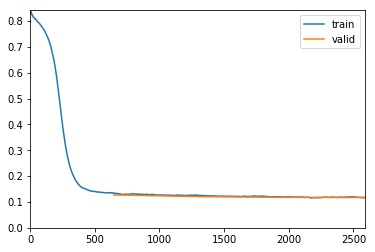

In [61]:
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,fbeta,time
0,0.119312,0.118763,0.443658,01:43
1,0.117077,0.116695,0.462199,01:43
2,0.114061,0.115770,0.465744,01:43


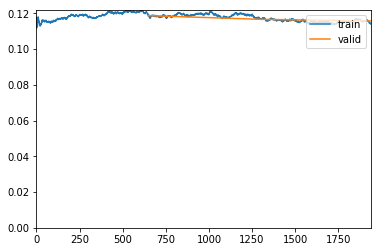

In [62]:
learn2.fit_one_cycle(3)

In [63]:
learn2.unfreeze()

In [64]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


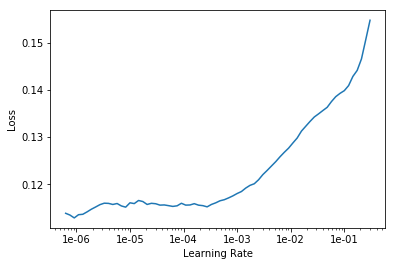

In [65]:
learn2.recorder.plot()

epoch,train_loss,valid_loss,fbeta,time
0,0.114817,0.115095,0.473807,02:16
1,0.112940,0.113953,0.482884,02:16
2,0.110951,0.113400,0.484104,02:16
3,0.108259,0.113334,0.484799,02:17


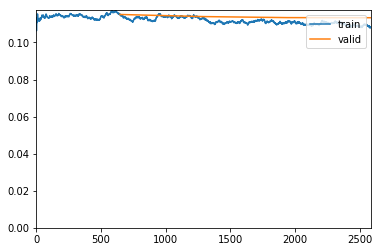

In [66]:
learn2.fit_one_cycle(4, slice(1e-6,1e-4))

In [67]:
learn2.save('texture_cleaned-resnet50-size150-fr7-unfr4', return_path=True)

PosixPath('Img/models/texture_cleaned-resnet50-size150-fr7-unfr4.pth')

In [68]:
learn2.export('texture_cleaned-resnet50-size150-fr7-unfr4')

In [69]:
interp2 = ClassificationInterpretation.from_learner(learn2)

5535 misclassified samples over 10366 samples in the validation set.


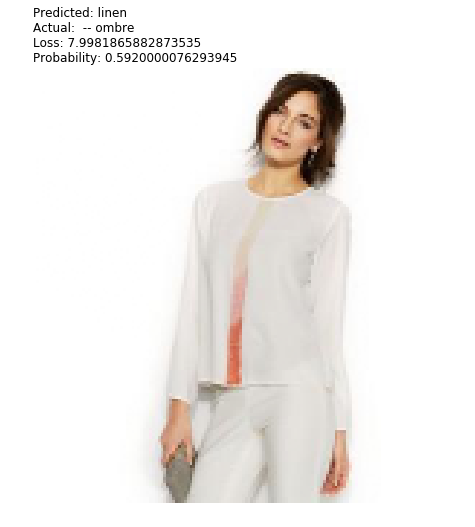

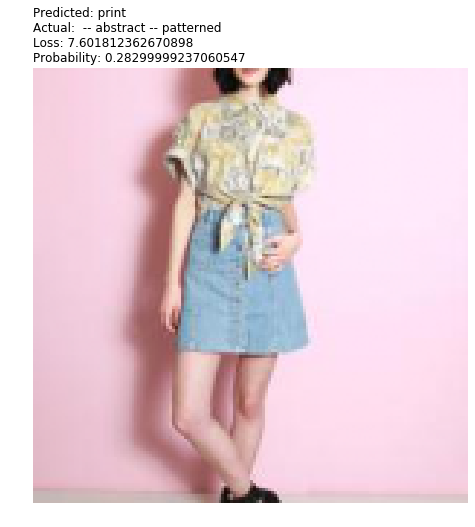

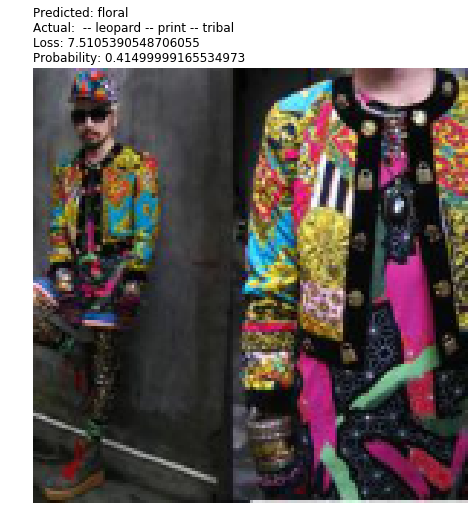

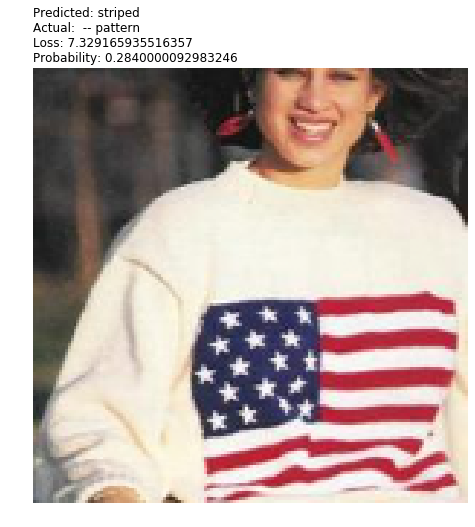

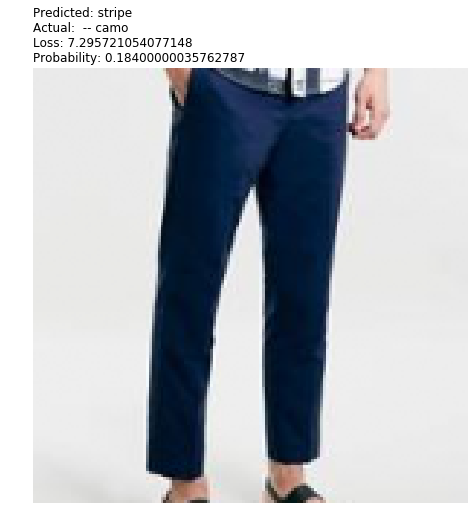

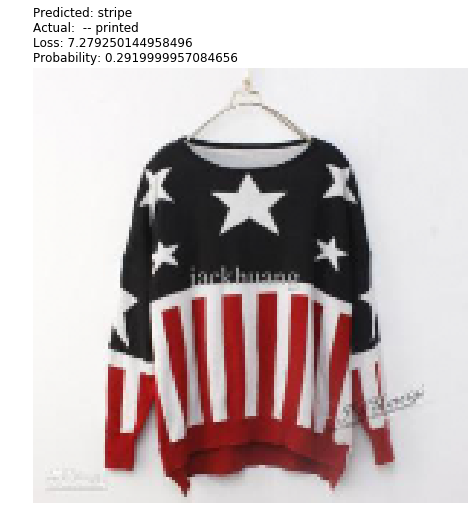

In [71]:
interp2.plot_multi_top_losses(6, figsize=(10,8))